In [1]:
#importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer,RobustScaler,MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score
import seaborn as sns
import joblib

In [2]:
def charger_fichier(path):
    ext = path.split(".")[-1]
    if ext in ['csv','txt']:
        data = pd.read_csv(path)
    elif ext in ['xls','xlsx']:
        data = pd.read_excel(path)
    return data

In [3]:
def normalisation(df, method):
    """
    Méthode permettant de normaliser les données quantitatives d'un dataframe
    @params df : Dataframe
    @params method: Entier compris entre 1 et 3
        1 => Utilisation de MinMax
        2 => Utilisation de Z-score
        3 => Utilisation de la méthode robuste (résiste aux valeurs aberrantes)
    """
    df_copy = df.copy()  # Utiliser une copie du DataFrame pour éviter de modifier l'original
    
    if method == 1:
        scaler = MinMaxScaler()
    elif method == 2:
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    
    scaled_data = scaler.fit_transform(df_copy.select_dtypes(include=['int', 'float']))
    df_copy.loc[:, df_copy.select_dtypes(include=['int', 'float']).columns] = scaled_data
    return df_copy,scaler

# Exploration des données

In [4]:
df = charger_fichier('donnees_generer_complet_consultations_medicales.xlsx')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age (en mois)  1160 non-null   float64
 1   Sexe           1160 non-null   object 
 2   Poids (kg)     1160 non-null   float64
 3   Symptômes      1160 non-null   object 
 4   Pathologie     1160 non-null   object 
 5   Traitement     1160 non-null   object 
dtypes: float64(2), object(4)
memory usage: 54.5+ KB


In [6]:
df.head(10)

,Age (en mois),Sexe,Poids (kg),Symptômes,Pathologie,Traitement
0,7.0,M,7.0,"Malnutrition, Entéropathie chronique, Insuffis...",Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
1,5.0,F,6.5,"Malnutrition, Insuffisance pondérale",Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
2,18.0,M,9.5,"Malnutrition, Insuffisance pondérale",Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
3,24.0,F,11.0,"Malnutrition, Insuffisance pondérale",Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
4,48.0,M,15.0,"Malnutrition, Insuffisance pondérale",Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
5,6.0,F,8.0,"Malnutrition, Insuffisance pondérale",Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
6,15.0,M,9.2,"Malnutrition, Insuffisance pondérale",Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
7,8.0,F,7.8,"Malnutrition, Entéropathie chronique, Insuffis...",Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
8,36.0,M,13.0,"Malnutrition, Insuffisance pondérale",Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
9,9.0,F,7.2,"Malnutrition, Insuffisance pondérale",Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."


In [7]:
df.describe(include='all')

,Age (en mois),Sexe,Poids (kg),Symptômes,Pathologie,Traitement
count,1160.000000,1160,1160.000000,1160,1160,1160
unique,NaN,2,NaN,262,29,146
top,NaN,M,NaN,"Plaques cutanées, diarrhée, démence",Amaigrissement,Désobstruction du nez par lavage au chlorure d...
freq,NaN,581,NaN,40,40,41
mean,300.815862,NaN,47.144655,NaN,NaN,NaN
std,226.674273,NaN,26.759522,NaN,NaN,NaN
min,2.000000,NaN,3.500000,NaN,NaN,NaN
25%,72.000000,NaN,18.000000,NaN,NaN,NaN
50%,324.000000,NaN,55.750000,NaN,NaN,NaN
75%,468.000000,NaN,70.000000,NaN,NaN,NaN


In [8]:
df.isnull().sum()

Age (en mois)    0
Sexe             0
Poids (kg)       0
Symptômes        0
Pathologie       0
Traitement       0
dtype: int64

# Transformation de la colonne Symptomes en 05 autres colonnes

In [9]:
symptomes = df['Symptômes'].str.lower()

# Diviser les symptômes en colonnes individuelles
for i, symptome in enumerate(symptomes):
    if isinstance(symptome, str):  # Vérifier si la valeur est une chaîne de caractères
        tabs = symptome.split(',')
        for j, tab in enumerate(tabs[:5]):
            df.at[i, f'Symptome_{j + 1}'] = tab.strip()

# Supprimer la colonne "Symptômes" originale
df = df.drop(columns=['Symptômes'])


In [10]:
# Sélectionnez les 5 dernières colonnes
dernieres_colonnes = df.iloc[:, -5:]

# Supprimez les 5 dernières colonnes du DataFrame original
df = df.iloc[:, :-5]

# Insérez les 5 dernières colonnes à la 3e position
position_inserer = 3  # L'index 2 correspond à la 3e position (index de base 0)
for col in dernieres_colonnes.columns:
    df.insert(position_inserer, col, dernieres_colonnes[col])



In [11]:
#Modalités de la variable cible
df.loc[:, 'Pathologie'].unique()

array(['Amaigrissement', 'Anémie', 'Angine', 'Anxiété', 'Bronchite aiguë',
       'Cystite aiguë', 'Dermatite séborrhéique', 'Furoncle',
       'Hypoglycémie', 'Hypoglycémie sévère', 'Insomnie', 'Onchocercose',
       'Otite externe aiguë', 'Otite moyenne aiguë (OMA)',
       'Otite moyenne chronique suppurée (OMCS)', 'Paludisme', 'Pellagre',
       'Poliomyélite', 'Prostatite aiguë', 'Reflux gastro-œsophagien',
       'Rhinite (rhume)', 'Rhinopharyngite', 'Rougeole',
       'Sinusite bactérienne', 'Sinusite virale', 'Stomatite du  scorbut',
       'Trachéite bactérienne', 'Trichomonase', 'Tuberculose pulmonaire'],
      dtype=object)

In [12]:
df.head()

,Age (en mois),Sexe,Poids (kg),Symptome_5,Symptome_4,Symptome_3,Symptome_2,Symptome_1,Pathologie,Traitement
0,7.0,M,7.0,NaN,NaN,insuffisance pondérale,entéropathie chronique,malnutrition,Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
1,5.0,F,6.5,NaN,NaN,NaN,insuffisance pondérale,malnutrition,Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
2,18.0,M,9.5,NaN,NaN,NaN,insuffisance pondérale,malnutrition,Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
3,24.0,F,11.0,NaN,NaN,NaN,insuffisance pondérale,malnutrition,Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."
4,48.0,M,15.0,NaN,NaN,NaN,insuffisance pondérale,malnutrition,Amaigrissement,"Supplémentation en vitamine A : à J1, J2, et J..."


# Suppresion des colonnes inutiles

In [13]:
useless_cols = ['Traitement']
df.drop(useless_cols,axis=1,inplace=True)
df.head()

,Age (en mois),Sexe,Poids (kg),Symptome_5,Symptome_4,Symptome_3,Symptome_2,Symptome_1,Pathologie
0,7.0,M,7.0,NaN,NaN,insuffisance pondérale,entéropathie chronique,malnutrition,Amaigrissement
1,5.0,F,6.5,NaN,NaN,NaN,insuffisance pondérale,malnutrition,Amaigrissement
2,18.0,M,9.5,NaN,NaN,NaN,insuffisance pondérale,malnutrition,Amaigrissement
3,24.0,F,11.0,NaN,NaN,NaN,insuffisance pondérale,malnutrition,Amaigrissement
4,48.0,M,15.0,NaN,NaN,NaN,insuffisance pondérale,malnutrition,Amaigrissement


In [14]:
df.isnull().sum()

Age (en mois)       0
Sexe                0
Poids (kg)          0
Symptome_5       1096
Symptome_4        960
Symptome_3        704
Symptome_2        207
Symptome_1          0
Pathologie          0
dtype: int64

In [15]:
df.fillna('aucun',inplace=True)

In [16]:
df.isnull().sum()

Age (en mois)    0
Sexe             0
Poids (kg)       0
Symptome_5       0
Symptome_4       0
Symptome_3       0
Symptome_2       0
Symptome_1       0
Pathologie       0
dtype: int64

# Normalisation 

In [17]:

df_normalized,scaler = normalisation(df, method=1)
# Remplacement des colonnes normalisées dans le DataFrame original
df = df_normalized

# Afficher le DataFrame après normalisation
df.head()

,Age (en mois),Sexe,Poids (kg),Symptome_5,Symptome_4,Symptome_3,Symptome_2,Symptome_1,Pathologie
0,0.005219,M,0.037838,aucun,aucun,insuffisance pondérale,entéropathie chronique,malnutrition,Amaigrissement
1,0.003132,F,0.032432,aucun,aucun,aucun,insuffisance pondérale,malnutrition,Amaigrissement
2,0.016701,M,0.064865,aucun,aucun,aucun,insuffisance pondérale,malnutrition,Amaigrissement
3,0.022965,F,0.081081,aucun,aucun,aucun,insuffisance pondérale,malnutrition,Amaigrissement
4,0.048017,M,0.124324,aucun,aucun,aucun,insuffisance pondérale,malnutrition,Amaigrissement


# Encodage des variables qualitatives

In [18]:
encoder_symptome = LabelBinarizer()
encoder_sexe = LabelBinarizer()
encoder_pathologie = LabelEncoder()


In [19]:
def encodage(data, columns, cible):
    
    symptomes = pd.concat([df['Symptome_1'], df['Symptome_2'], df['Symptome_3'], df['Symptome_4'], df['Symptome_5']])
    encoder_symptome.fit(symptomes)
    
    #Encodage des variables explicatives qualitative avec LabelBinarizer
    cat_col = list(_ for _ in columns)
    for col in cat_col:
        if col != 'Pathologie' and col!='Sexe':
            enc_data = encoder_symptome.transform(data.loc[:, col].astype(str))
            prev_mod = [f"{col}_{mod}" for mod in list(encoder_symptome.classes_)]
            if(len(prev_mod)==enc_data.shape[1]):
                data[prev_mod] = enc_data
                data.drop(col,axis=1,inplace=True)
            else:
                data.drop(col,axis=1,inplace=True) 
                data[col] = enc_data
        elif col == 'Sexe':
            enc_data = encoder_sexe.fit_transform(data.loc[:, col].astype(str))
            data.drop(col,axis=1,inplace=True)
            data[col] = enc_data
            
    #Encodage de la variable cible avec LabelEncoder
    enc_cible = encoder_pathologie.fit_transform(data.loc[:,cible])
    data.drop(cible,axis=1,inplace=True)
    data[cible] = enc_cible
            
    return data
                                            

In [20]:
#Liste des variables categorielles a encoder
cols_to_encoder = df.select_dtypes(include=['object']).columns
cols_to_encoder

Index(['Sexe', 'Symptome_5', 'Symptome_4', 'Symptome_3', 'Symptome_2',
       'Symptome_1', 'Pathologie'],
      dtype='object')

In [21]:
df=encodage(df,cols_to_encoder,'Pathologie')

/var/folders/rd/408jh18j04b0rjlsj8z_718m0000gn/T/ipykernel_40747/403850940.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[prev_mod] = enc_data
/var/folders/rd/408jh18j04b0rjlsj8z_718m0000gn/T/ipykernel_40747/403850940.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[prev_mod] = enc_data
/var/folders/rd/408jh18j04b0rjlsj8z_718m0000gn/T/ipykernel_40747/403850940.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

In [22]:
df = df.reindex(sorted(df.columns), axis=1)
df.isnull().sum()

Age (en mois)                                   0
Pathologie                                      0
Poids (kg)                                      0
Sexe                                            0
Symptome_1_adénopathies                         0
                                               ..
Symptome_5_écoulement vaginal jaune-verdâtre    0
Symptome_5_écoulement vaginal malodorant        0
Symptome_5_éruption cutanée                     0
Symptome_5_état de choc                         0
Symptome_5_éternuements                         0
Length: 884, dtype: int64

In [23]:
# Exportez les données traitées vers un fichier CSV
df.to_csv('donnees_traites.csv', index=False)


In [24]:
prepared_data = charger_fichier('donnees_traites.csv')

In [25]:
prepared_data.shape

(1160, 884)

## Nombres de pathologies présentent

In [26]:
len(prepared_data.loc[:, 'Pathologie'].unique())

29

# Separation des donnees en Train et Test

In [27]:
y = prepared_data['Pathologie']
X = prepared_data.drop('Pathologie',axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [29]:
X_train.shape

(928, 883)

In [30]:
X_test.shape


(232, 883)

## Recherche du meilleur estimateur avec ses parametres avec GridSearchCv

In [31]:
models = parametres_grid = [
    ('K-Nearest Neighbors (KNN)', KNeighborsClassifier(), {
        "n_neighbors": np.arange(1, 20),
        "metric": ["euclidean", "manhattan"],
        "weights": ["uniform", "distance"]
    }),
    
    

    ('Decision Tree', DecisionTreeClassifier(), {
        "criterion": ["gini", "entropy"],
        "splitter": ["best", "random"],
        "max_depth": [None, 2, 4, 6, 8, 10],
        "min_samples_split": np.arange(2, 10, 1),
        "min_samples_leaf": list(range(1, 10, 1))
    }),

    ('Random Forest', RandomForestClassifier(), {
        "criterion": ["gini", "entropy"],
        "n_estimators": [50, 100, 150],
        "max_features": ["auto", "sqrt", "log2"],
        "max_depth": [None, 1, 3, 5, 7, 9]
    }),

    ('Bagging', BaggingClassifier(), {
        "n_estimators": [10, 20, 30],
        "max_samples": np.arange(0.1, 1.1, 0.1),
        "max_features": np.arange(0.1, 1.1, 0.1)
    }),

    ('Logistic Regression', LogisticRegression(max_iter=10000, multi_class='multinomial'), {
        "C": np.logspace(-3, 3, 7),
        "penalty": ["l1", "l2"],
        "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
    }),
   

    ('Naive Bayes', MultinomialNB(), { 
        "alpha": [0.1, 0.5, 1.0], 
        "fit_prior": [True, False]  
    }),

]


model_names = []
best_parametre = []
score = []
bons_model  = []
# Boucle pour tester chaque modèle avec GridSearchCV
for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5,scoring='accuracy',n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_score = grid_search.score(X_test, y_test)
    score.append(grid_score)
    model_names.append(model_name)
    best_parametre.append(grid_search.best_params_)
    bons_model.append(grid_search)
    

/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as 

In [32]:
model_search = pd.DataFrame({"Algorithme": model_names, "Meilleur parametres": best_parametre, "score" : score, "model_al" : bons_model})


In [33]:
model_search.sort_values(by='score', ascending=False)

,Algorithme,Meilleur parametres,score,model_al
2,Random Forest,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.969828,"GridSearchCV(cv=5, estimator=RandomForestClass..."
4,Logistic Regression,"{'C': 100.0, 'penalty': 'l2', 'solver': 'newto...",0.961207,"GridSearchCV(cv=5,\n estimator=Log..."
0,K-Nearest Neighbors (KNN),"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.952586,"GridSearchCV(cv=5, estimator=KNeighborsClassif..."
5,Naive Bayes,"{'alpha': 0.1, 'fit_prior': True}",0.952586,"GridSearchCV(cv=5, estimator=MultinomialNB(), ..."
1,Decision Tree,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.935345,"GridSearchCV(cv=5, estimator=DecisionTreeClass..."
3,Bagging,"{'max_features': 0.30000000000000004, 'max_sam...",0.896552,"GridSearchCV(cv=5, estimator=BaggingClassifier..."


In [58]:
model= model_search['model_al'][5]
model.best_params_

{'alpha': 0.1, 'fit_prior': True}

In [77]:
precisions = []
accuracies = []
f1_scores = []
recalls  = []
trains  = []
confusion_matrices = []
index  = model_search['Algorithme']
for i in range(0,len(model_search)):
    model= model_search['model_al'][i]
    precisions.append(precision_score(y_test, model.predict(X_test),average='weighted')*100)
    accuracies.append(model_search['score'][i]*100)
    recalls.append(recall_score(y_test, model.predict(X_test),average='weighted')*100)
    f1_scores.append(f1_score(y_test, model.predict(X_test),average='weighted')*100)
    trains.append(model.score(X_train,y_train)*100)
    cm = confusion_matrix(y_test, model.predict(X_test))
    confusion_matrices.append(cm)

In [78]:
results = {'Accuracy': accuracies,
          'Recall': recalls,
          'Precision': precisions,
          'F1-score': f1_scores}

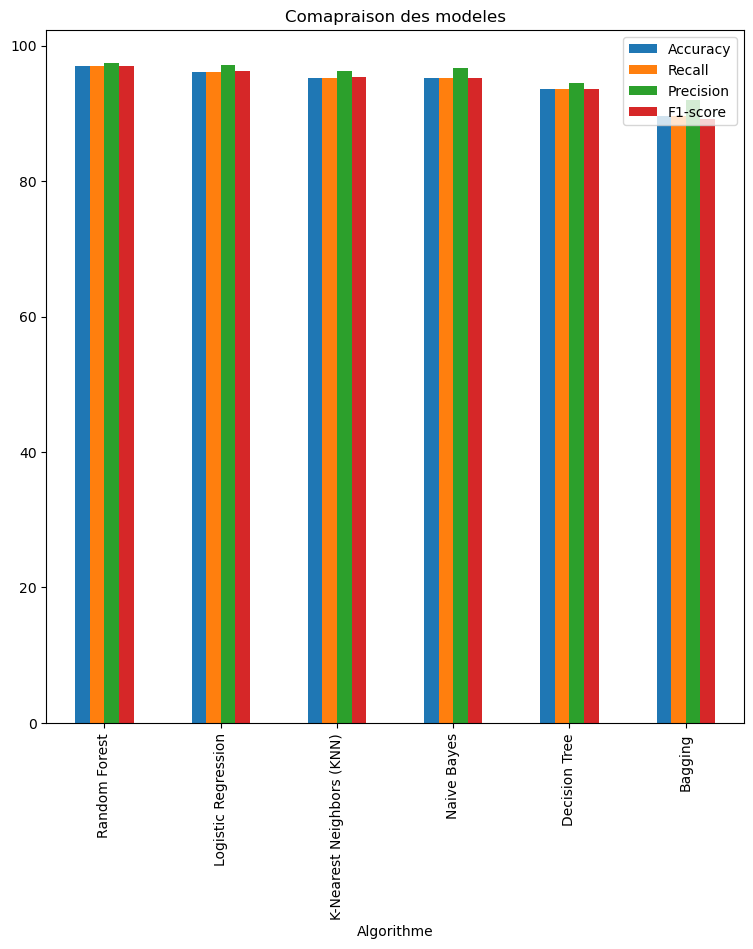

In [79]:
results = pd.DataFrame(results,index=index)
results = results.sort_values(by='Accuracy',ascending=False)
fig =results.plot(kind='bar',title='Comapraison des modeles',figsize =(9,9)).get_figure()
fig.savefig('Final Result.png')

In [80]:
results  

,Accuracy,Recall,Precision,F1-score
Algorithme,,,,
Random Forest,96.982759,96.982759,97.428674,97.031178
Logistic Regression,96.120690,96.120690,97.077491,96.204752
K-Nearest Neighbors (KNN),95.258621,95.258621,96.308684,95.292974
Naive Bayes,95.258621,95.258621,96.662748,95.243884
Decision Tree,93.534483,93.534483,94.485806,93.610778
Bagging,89.655172,89.655172,91.906317,89.168917


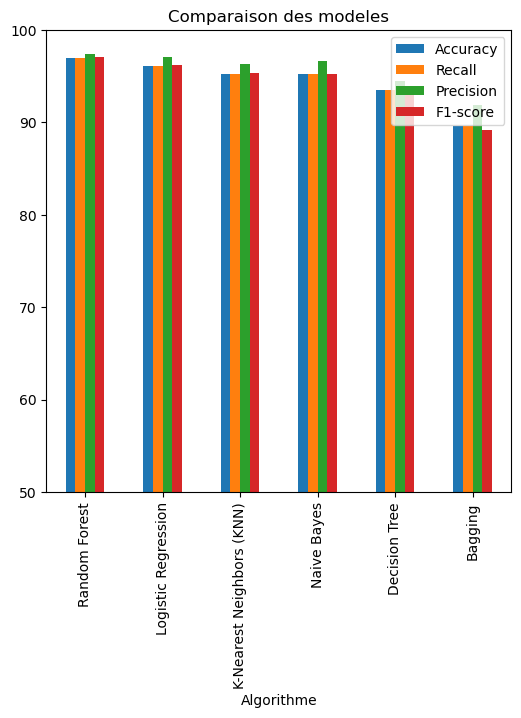

In [81]:
fig =results.plot(kind='bar',title='Comparaison des modeles',figsize =(6,6),ylim=[50,100]).get_figure()
fig.savefig('image.png')

array([<Axes: title={'center': 'Accuracy'}, xlabel='Algorithme'>,
       <Axes: title={'center': 'Recall'}, xlabel='Algorithme'>,
       <Axes: title={'center': 'Precision'}, xlabel='Algorithme'>,
       <Axes: title={'center': 'F1-score'}, xlabel='Algorithme'>],
      dtype=object)

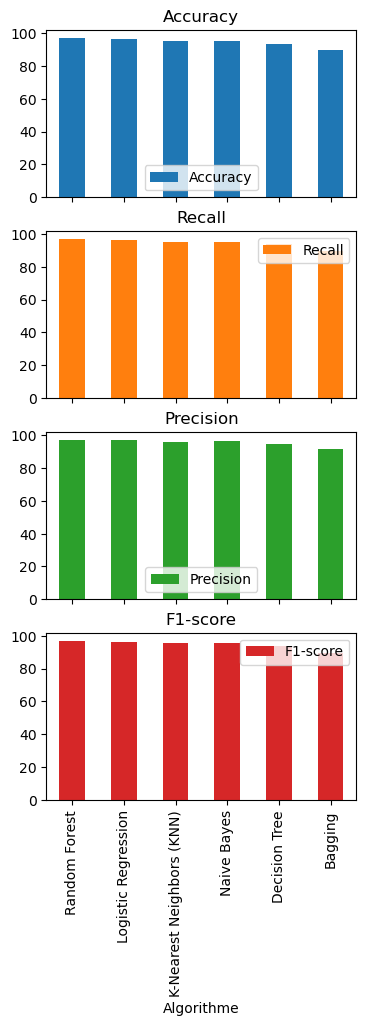

In [82]:
results.plot(subplots=True,kind ='bar',figsize=(4,10))

## Matrice de confusion

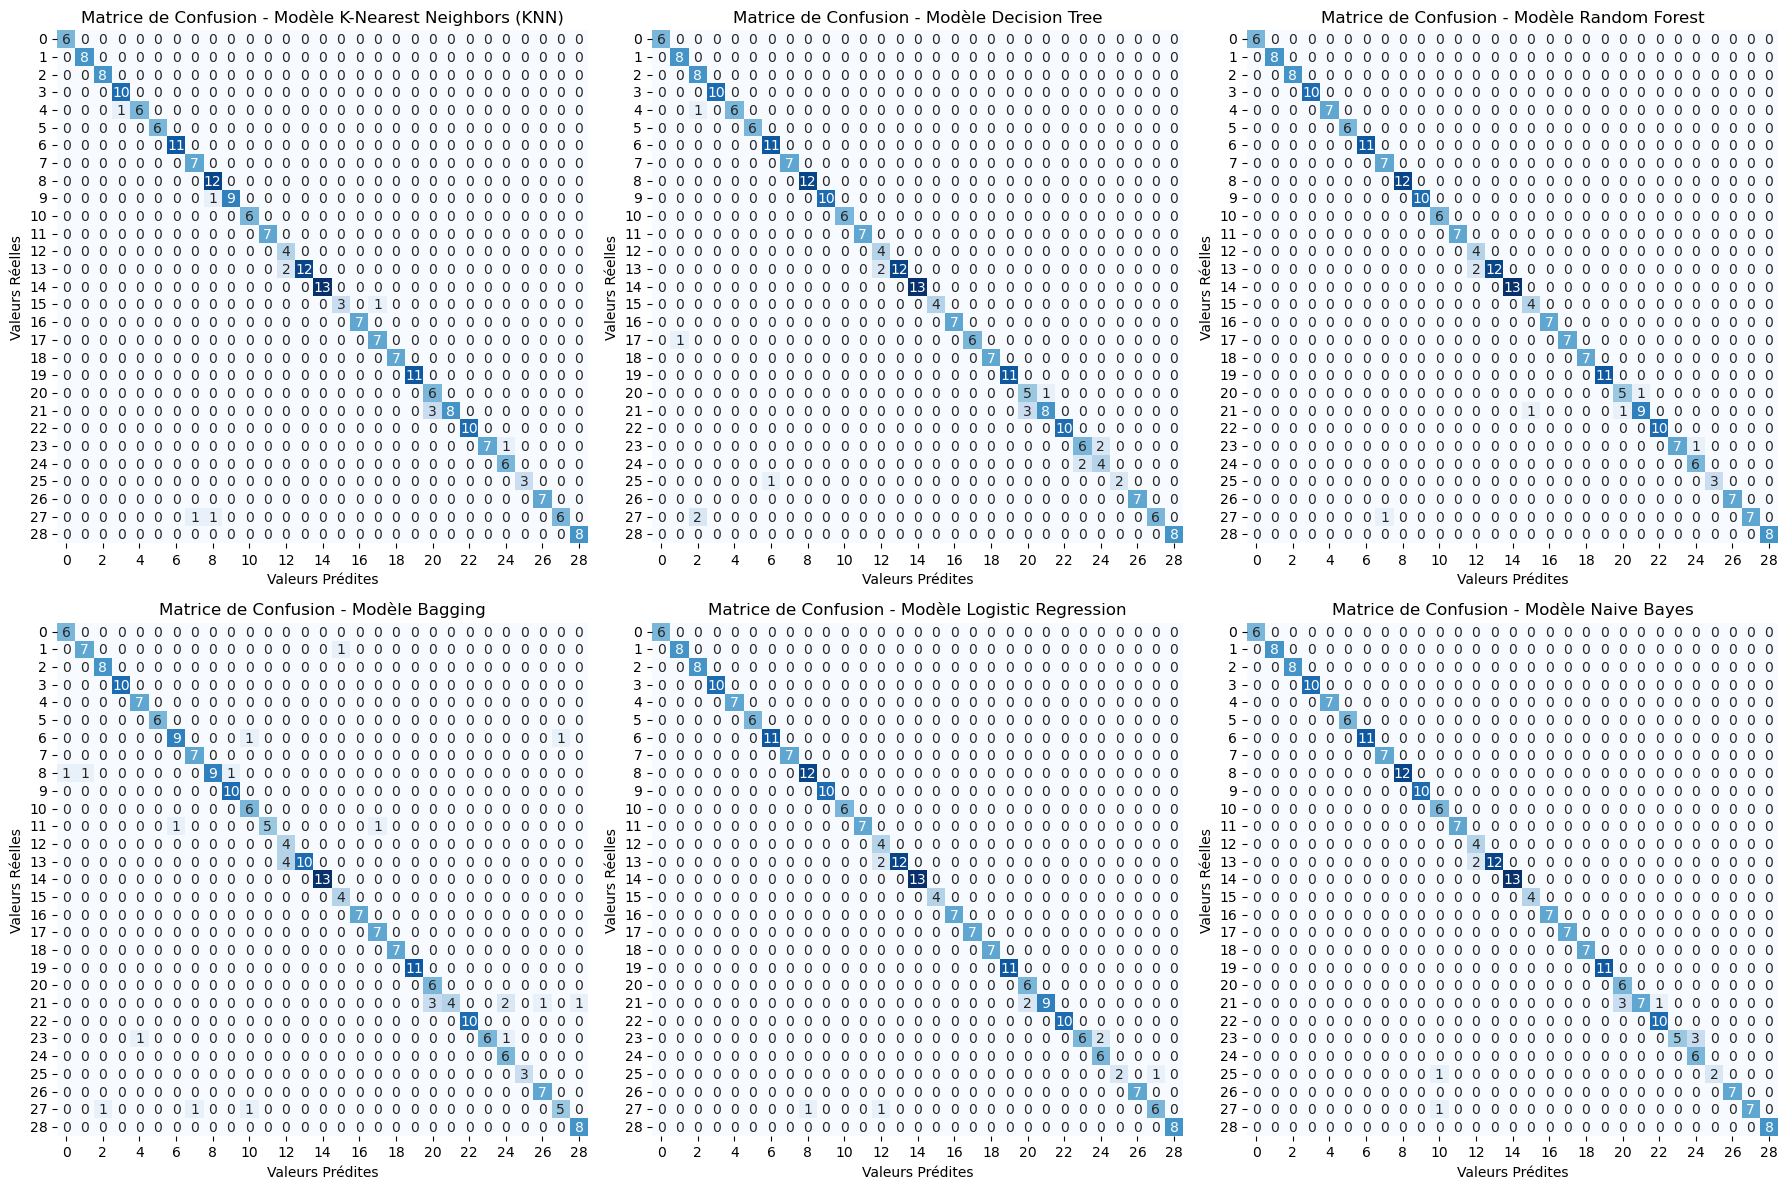

In [83]:

# Affichage des heatmaps des matrices de confusion pour chaque modèle
plt.figure(figsize=(18, 12))
for i, cm in enumerate(confusion_matrices, 1):
    plt.subplot(2, 3, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matrice de Confusion - Modèle {index[i-1]}")
    plt.xlabel("Valeurs Prédites")
    plt.ylabel("Valeurs Réelles")

plt.tight_layout()
plt.show()

# Enregistrement des models dans des fichiers

In [84]:
from diseases_prediction_model import DiseasesPredictionModel


In [85]:
repertoire_sauvegarde = "/Users/maestro/Documents/Data_science_books/stage_master_ginfo_cloud/modele_prediction/"


In [86]:
# save the models to disk
normalizer = scaler
encoder_dict = {
    'Sexe': encoder_sexe,
    'Symptome_5': encoder_symptome,
    'Symptome_4': encoder_symptome,
    'Symptome_3': encoder_symptome,
    'Symptome_2': encoder_symptome,
    'Symptome_1': encoder_symptome,
    'Pathologie': encoder_pathologie
}
for i in range(0,len(model_search)):
    model= model_search['model_al'][i]
    save_model = DiseasesPredictionModel(model,encoder_dict,normalizer)
    nom_fichier = f'modele_{index[i]}.joblib'
    chemin_complet = repertoire_sauvegarde + nom_fichier
    joblib.dump(save_model, chemin_complet)


# Test de predictions en rechargant les models stocker

In [87]:
algorithmes = ["K-Nearest Neighbors (KNN)","Decision Tree","Random Forest","Bagging","Logistic Regression","Naive Bayes"]
models={}
for al in algorithmes:
    nom_fichier = f'modele_{al}.joblib'
    chemin_complet = repertoire_sauvegarde + nom_fichier
    modele_charge = joblib.load(chemin_complet)
    models.__setitem__(al,modele_charge)

In [88]:
exemple = {
    "Age (en mois)" : 420,	
    "Sexe" : "M",
    "Poids (kg)" : 80,	
    "Symptome_5" : "aucun",		
    "Symptome_4" : "aucun",	
    "Symptome_3" : "aucun",	
    "Symptome_2" : "insuffisance pondérale",
    "Symptome_1" : "malnutrition",
    }

In [89]:
classes_pred=[]
probas_pred=[]

for algo, model in models.items():
    classe,proba = model.predict_disease(exemple)
    if classe:
        classes_pred.append(classe)
        probas_pred.append(proba)
    else:
        print("Données non valides.")
            
resultats_predictions = pd.DataFrame({"Algorithme": algorithmes, "Pathologie prédite": classes_pred, "Probabilités" : probas_pred})


/Users/maestro/Documents/Data_science_books/stage_master_ginfo_cloud/modele_prediction/diseases_prediction_model.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[prev_mod] = enc_data
/Users/maestro/Documents/Data_science_books/stage_master_ginfo_cloud/modele_prediction/diseases_prediction_model.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[prev_mod] = enc_data
/Users/maestro/Documents/Data_science_books/stage_master_ginfo_cloud/modele_prediction/diseases_prediction_model.py:28: PerformanceWarning: DataFrame is h

In [90]:
resultats_predictions

,Algorithme,Pathologie prédite,Probabilités
0,K-Nearest Neighbors (KNN),Amaigrissement,1.000000
1,Decision Tree,Amaigrissement,1.000000
2,Random Forest,Amaigrissement,0.586667
3,Bagging,Amaigrissement,0.370817
4,Logistic Regression,Amaigrissement,0.991554
5,Naive Bayes,Amaigrissement,0.998530


In [91]:
# Comptage du nombre de modèles qui prédisent chaque classe
predictions_count = {}
seuil_decision = 3

# Créer un dictionnaire pour stocker les probabilités de chaque classe
classe_probabilities = {}

for index, row in resultats_predictions.iterrows():
    classe_predite = row['Pathologie prédite']
    probabilite = row['Probabilités'] 
    if classe_predite not in predictions_count:
        predictions_count[classe_predite] = 0
        classe_probabilities[classe_predite] = []
    predictions_count[classe_predite] += 1
    classe_probabilities[classe_predite].append(probabilite)

# Sélection de la prédiction finale
predictions_finales = []
for classe, count in predictions_count.items():
    if count >= seuil_decision:
        moyenne_probabilites = sum(classe_probabilities[classe]) / count
        if moyenne_probabilites >= 0.75:
            predictions_finales.append((classe, count))

# Trie des prédictions finales par nombre de prédictions (du plus élevé au plus bas)
predictions_finales.sort(key=lambda x: x[1], reverse=True)

# La classe la plus fréquente parmi les prédictions finales est la prédiction finale
if predictions_finales:
    classe_predite_finale = predictions_finales[0][0]
    print("Classe prédite finale:", classe_predite_finale)
else:
    print("Aucune prédiction ne dépasse le seuil de décision.")
    



Classe prédite finale: Amaigrissement
